In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("talk") #[poster, paper, talk, notebook]

### load lidar

In [2]:
fname = '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow.nc' #3m BSU
#open data
ds = xr.open_dataset(fname, chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'
ds=ds.astype(np.int16, copy=False)

### load terrain

In [3]:
fpath = '/Users/meganmason491/Documents/research/sierra/data/terrain/*flipped*.nc' #BSU
# fpath = '' #mac

ts=xr.open_mfdataset(fpath, 
                     concat_dim=None, 
                     combine='nested', 
                     chunks={'x':1000, 'y':1000}, 
                     parallel=True) 
ts = ts.where(ds.mask==1)
ts.close()

### 3k subregion (Acker Meadow and Peak)

In [4]:
#create 3k_subregions (with new veg layer, because can not locate og 3k_subregions, made 1/2/2020)
d = ds.isel(x=slice(8400,9400), y=slice(3000,4000))
t = ts.isel(x=slice(8400,9400), y=slice(3000,4000))
# d.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion_nVeg.nc')

In [5]:
ds=d
ds.close()

ts=t
ts.close()

In [19]:
def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy


def plot_sd(ds, title, time=31, cmap='Blues', vmax=300):
    plt.figure(figsize=(10, 8))
    s = ds.isel(time=time)
    x_gt0 = s.snow.where(s.snow>0)
    x_gt0.plot.imshow(x='x', y='y', cmap=cmap, vmax=300, cbar_kwargs={'label': 'Snow Depth [cm]'})
    plt.tight_layout()

    
def plot_dem(ds, title, ctour_int=5, cmap='gray', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int)
    h = ds.dem.plot.imshow(x='x', y='y', cmap=cmap, alpha=.9, cbar_kwargs={'label': 'Elevation [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{} \n{}'.format(title))
    plt.tight_layout()

    
def plot_veg_hgt(ds, title, ctour_int=5, cmap='Greens', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    levels=np.round(np.arange(1500,4000,ctour_int), -2)
#     levels = np.round(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -2) #1000 m
#     levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    v = ds.veg.plot.imshow(x='x', y='y', cmap=cmap, alpha=.7, vmax=10, cbar_kwargs={'label': 'Vegetation Height [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()


def plot_aspect(ts, title, slp_filter=10, ctour_int=5, ctour_lines='k'):
    plt.figure(figsize=(25,15))
    #set up
    lvls = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    levels=np.round(np.arange(1500,4000,ctour_int), -2)
#     levels = np.round(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -2) #1000 m
#     levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    # labels = ['North', '', 'East', '', 'South', '', 'West'] #CANT MAKE THIS WORK, would be nice to lable cbar
    s_gt10 = ts.where(ts.slope>=slp_filter) #eliminate aspects where the slope is <10 deg
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    a = s_gt10.aspect.plot.imshow(x='x', y='y', 
                                 colors= ['black','salmon','salmon','navajowhite','navajowhite', 'rebeccapurple','rebeccapurple','black'], 
                                 levels=lvls,
                                 alpha=.65,
                                 cbar_kwargs={'label': 'Aspect'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()

    
def plot_slope(ts, title, s_gt=15, ctour_int=5, ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    levels=np.round(np.arange(1500,4000,ctour_int), -2)
#     levels = np.round(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -2) #1000 m
#     levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    s_gt15 = ts.slope.where(ts.slope>s_gt)
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    s = s_gt15.plot.imshow(x='x', y='y', 
                                 cmap='Wistia', 
                                 alpha=.65,
                                 cbar_kwargs={'label': 'slope'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()
    


def plot_snow_series(ds, title, time=slice(2,51,5), cmap='Blues', vmax=300):
    plt.figure(figsize=(15, 10))
    s = ds.isel(time=time).snow.plot(x='x', y='y', col='time', 
                                              cmap=cmap, vmax=vmax, 
                                              cbar_kwargs={'label': 'Snow Depth [cm]'})

def z_score(ds, time=slice(1,51,1), exclude_zeros=True):
    ds = ds.isel(time=time)
    x_gt0 = ds.snow.where(ds.snow>0) #snow depth > 0cm
    
    if exclude_zeros is True:
        return (ds.snow - x_gt0.mean(dim=('x','y')) / x_gt0.std(dim=('x','y')))
    else: 
        return (ds.snow - ds.snow.mean(dim=('x','y')) / ds.snow.std(dim=('x','y')))

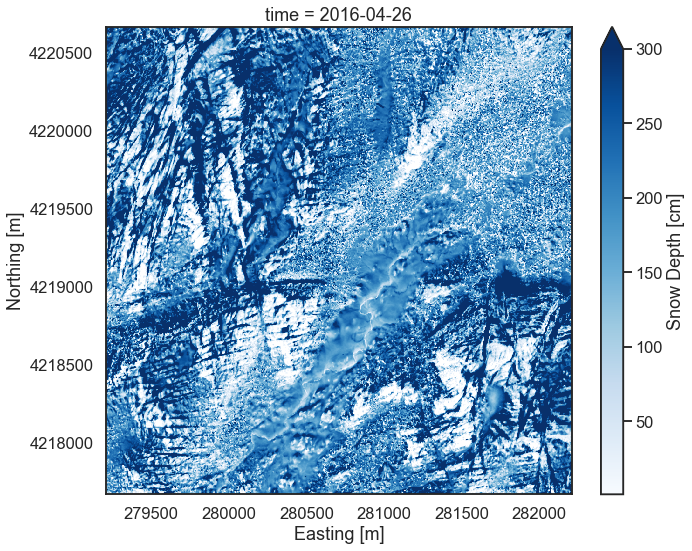

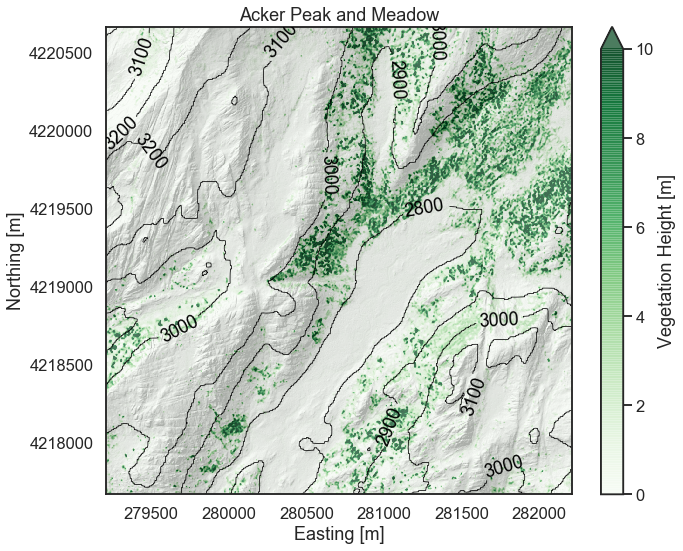

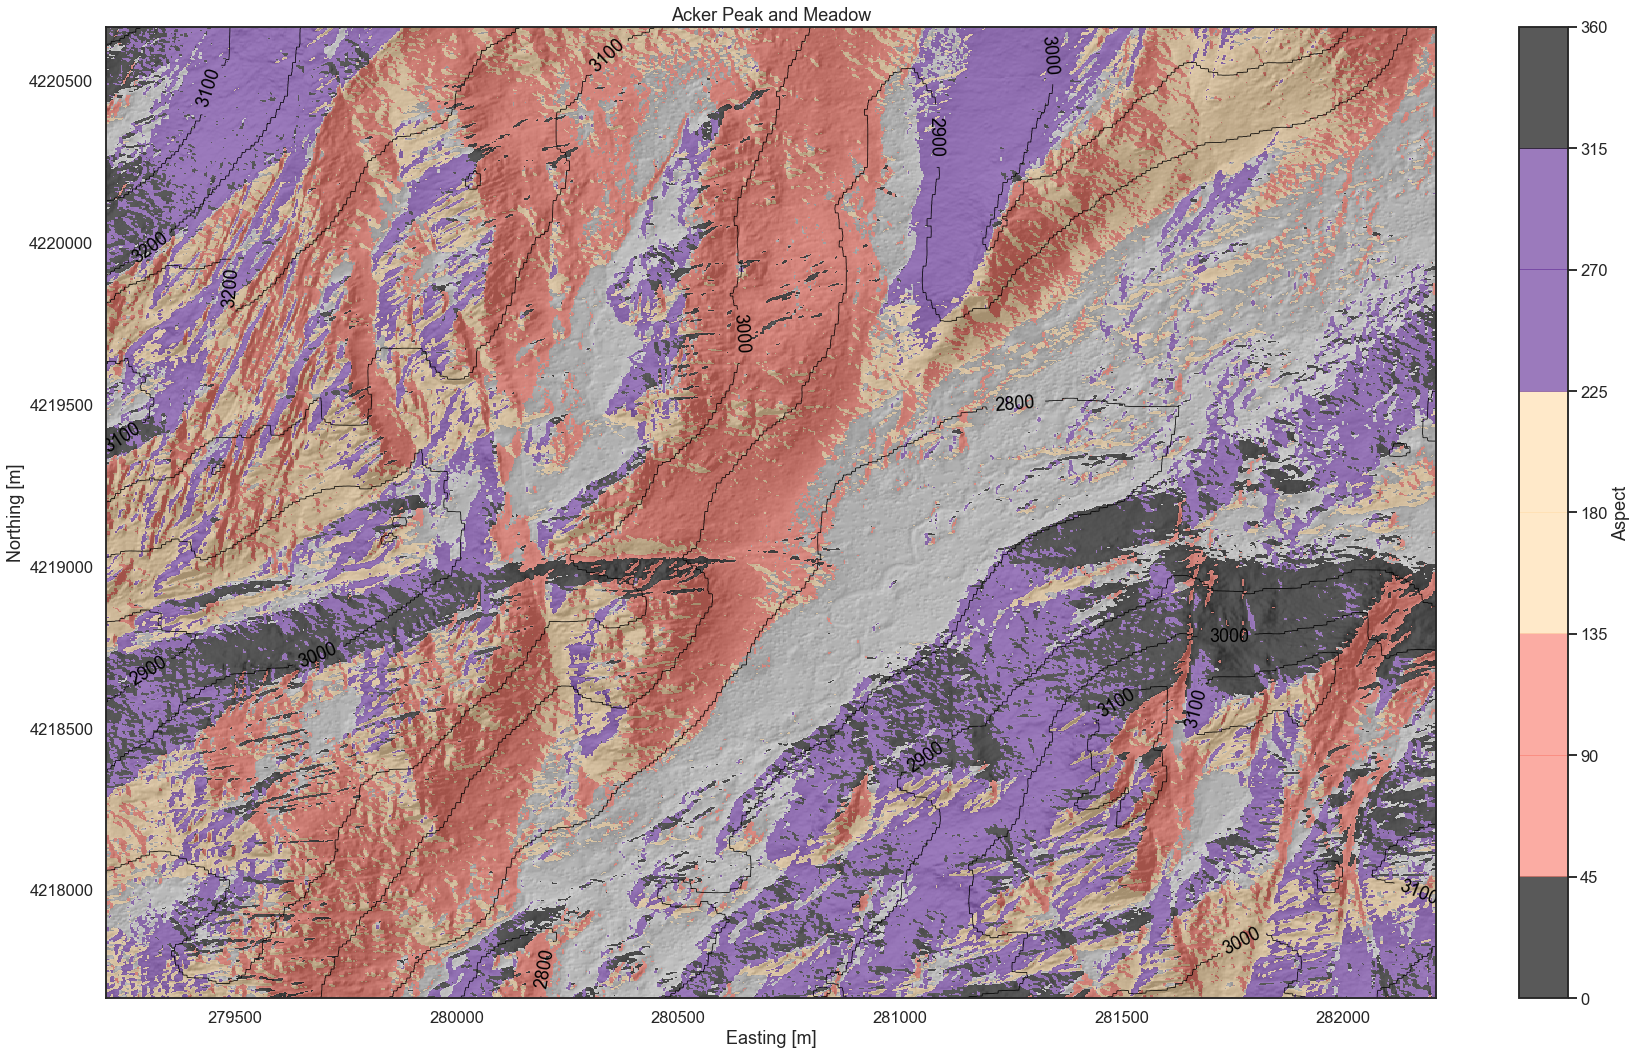

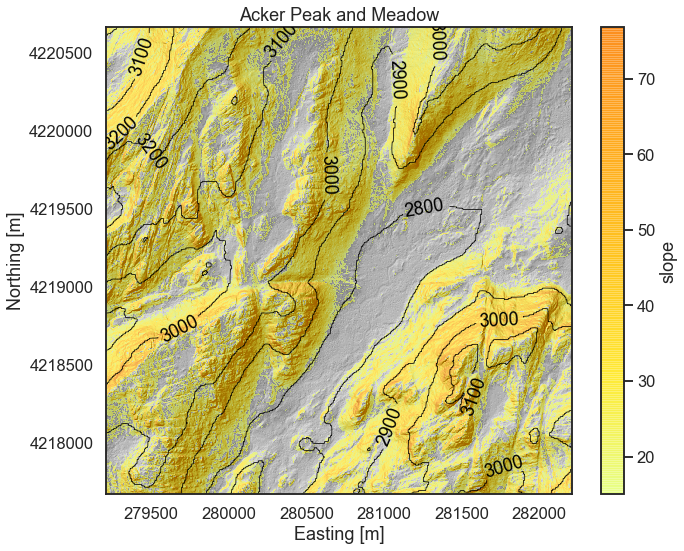

In [20]:
stns_longname = 'Acker Peak and Meadow'
stns_lc = '3k'
sns.set_style('white') # set up seaborn defaults (warnings w/o inside loop..?)
sns.set_context("talk")
dx, dy = subregion_size(ds) #subregion size -- used in figure naming

plot_sd(ds, title=(stns_longname))
# plt.savefig('../figs/{}_sno_{}m.png'.format(stns_lc, int(round(dx,-1))), dpi=300)

plot_veg_hgt(ds, title=stns_longname, ctour_int=100) #plot veg of subregion (use 50 for 1000m)
# plt.savefig('../figs/{}_veg_{}m.png'.format(stns_lc, int(round(dx,-1))), dpi=300)

plot_aspect(ts, title=stns_longname, ctour_int=100)
# plt.savefig('../figs/{}_asp_{}m.png'.format(stns_lc, int(round(dx,-1))), dpi=300)

plot_slope(ts, title=stns_longname, ctour_int=100)
# plt.savefig('../figs/{}_slp_{}m.png'.format(stns_lc, int(round(dx,-1))), dpi=300)